In [1]:
# pip install pyspark

In [2]:
import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import mean, stddev, min, max, col, count, when, isnan, lower, trim, regexp_replace, avg

# Configurar la variable de entorno para SPARK_LOCAL_IP
os.environ["SPARK_LOCAL_IP"] = "192.168.1.97"

In [3]:
# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("ETL and Metrics Calculation with Spark") \
    .config("spark.driver.bindAddress", "192.168.1.97") \
    .getOrCreate()

# Ajustar el nivel de registro a ERROR
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/17 13:56:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Cargar datos desde un archivo CSV
df = spark.read.csv('../data/processed/dataset_corredores.csv', header=True, inferSchema=True, sep=";")

print("Nombres de las columnas originales:")
print(df.columns)

Nombres de las columnas originales:
['edad', 'sexo', 'altura', 'peso', 'num calzado', 'articulacion', 'localizacion', 'lado', 'actividad principal', 'marca 10k', 'especialidad', 'km/sem', 'calzado 1', 'calzado 2', 'pace_walk', 'velocidad_walk', 'step rate_walk', 'stride length_walk', 'flight ratio_walk', 'power_walk', 'shock_walk', 'impact gs_walk', 'braking gs_walk', 'footstrike type_walk', 'pronation excursion_walk', 'max pronation velocity_walk', 'peak vertical grf_walk', 'contact ratio_walk', 'stride angle_walk', 'leg spring stiffness_walk', 'vertical spring stiffness_walk', 'vertical grf rate_walk', 'total force rate_walk', 'step length_walk', 'pronation excursion (mp->to)_walk', 'stance excursion (fs->mp)_walk', 'stance excursion (mp->to)_walk', 'pace_run', 'velocidad_run', 'step rate_run', 'stride length_run', 'flight ratio_run', 'power_run', 'shock_run', 'impact gs_run', 'braking gs_run', 'footstrike type_run', 'pronation excursion_run', 'max pronation velocity_run', 'peak vert

In [5]:
# Crear una lista de columnas con nombres limpios
cleaned_columns = [col.strip().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace('>', '') for col in df.columns]
df = df.toDF(*cleaned_columns) 
print("Nombres de las columnas limpios:")
print(df.columns)

Nombres de las columnas limpios:
['edad', 'sexo', 'altura', 'peso', 'num_calzado', 'articulacion', 'localizacion', 'lado', 'actividad_principal', 'marca_10k', 'especialidad', 'km/sem', 'calzado_1', 'calzado_2', 'pace_walk', 'velocidad_walk', 'step_rate_walk', 'stride_length_walk', 'flight_ratio_walk', 'power_walk', 'shock_walk', 'impact_gs_walk', 'braking_gs_walk', 'footstrike_type_walk', 'pronation_excursion_walk', 'max_pronation_velocity_walk', 'peak_vertical_grf_walk', 'contact_ratio_walk', 'stride_angle_walk', 'leg_spring_stiffness_walk', 'vertical_spring_stiffness_walk', 'vertical_grf_rate_walk', 'total_force_rate_walk', 'step_length_walk', 'pronation_excursion_mp_to_walk', 'stance_excursion_fs_mp_walk', 'stance_excursion_mp_to_walk', 'pace_run', 'velocidad_run', 'step_rate_run', 'stride_length_run', 'flight_ratio_run', 'power_run', 'shock_run', 'impact_gs_run', 'braking_gs_run', 'footstrike_type_run', 'pronation_excursion_run', 'max_pronation_velocity_run', 'peak_vertical_grf_run

In [6]:
print(f"Conteo de registros: {df.count()}")

Conteo de registros: 717


In [7]:
df.printSchema() # Mostrar esquema del DataFrame

root
 |-- edad: integer (nullable = true)
 |-- sexo: integer (nullable = true)
 |-- altura: integer (nullable = true)
 |-- peso: double (nullable = true)
 |-- num_calzado: double (nullable = true)
 |-- articulacion: string (nullable = true)
 |-- localizacion: string (nullable = true)
 |-- lado: string (nullable = true)
 |-- actividad_principal: string (nullable = true)
 |-- marca_10k: double (nullable = true)
 |-- especialidad: string (nullable = true)
 |-- km/sem: string (nullable = true)
 |-- calzado_1: string (nullable = true)
 |-- calzado_2: string (nullable = true)
 |-- pace_walk: double (nullable = true)
 |-- velocidad_walk: double (nullable = true)
 |-- step_rate_walk: double (nullable = true)
 |-- stride_length_walk: double (nullable = true)
 |-- flight_ratio_walk: double (nullable = true)
 |-- power_walk: double (nullable = true)
 |-- shock_walk: double (nullable = true)
 |-- impact_gs_walk: double (nullable = true)
 |-- braking_gs_walk: double (nullable = true)
 |-- footstrik

In [8]:
# Seleccionar las columnas de interés
columns_of_interest = ['actividad_principal', 'marca_10k', 'especialidad', 'km/sem', 'calzado_1', 'calzado_2']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+-------------------+---------+------------+------+---------+---------+
|actividad_principal|marca_10k|especialidad|km/sem|calzado_1|calzado_2|
+-------------------+---------+------------+------+---------+---------+
|                539|      598|         653|   598|      486|      553|
+-------------------+---------+------------+------+---------+---------+



In [9]:
# Seleccionar las columnas de interés
columns_of_interest = ['fpi_total_i', 'fpi_total_d']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+-----------+-----------+
|fpi_total_i|fpi_total_d|
+-----------+-----------+
|         11|         11|
+-----------+-----------+



In [10]:
columns_of_interest = ['pace_run', 'velocidad_run', 'step_rate_run', 'stride_length_run', 'flight_ratio_run', 'power_run']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+--------+-------------+-------------+-----------------+----------------+---------+
|pace_run|velocidad_run|step_rate_run|stride_length_run|flight_ratio_run|power_run|
+--------+-------------+-------------+-----------------+----------------+---------+
|     377|          377|          377|              378|             377|      377|
+--------+-------------+-------------+-----------------+----------------+---------+



In [11]:
columns_of_interest = ['shock_run', 'impact_gs_run', 'braking_gs_run', 'footstrike_type_run', 'pronation_excursion_run']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+---------+-------------+--------------+-------------------+-----------------------+
|shock_run|impact_gs_run|braking_gs_run|footstrike_type_run|pronation_excursion_run|
+---------+-------------+--------------+-------------------+-----------------------+
|      377|          377|           377|                377|                    377|
+---------+-------------+--------------+-------------------+-----------------------+



In [12]:
columns_of_interest = ['max_pronation_velocity_run', 'peak_vertical_grf_run', 'contact_ratio_run', 'stride_angle_run']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+--------------------------+---------------------+-----------------+----------------+
|max_pronation_velocity_run|peak_vertical_grf_run|contact_ratio_run|stride_angle_run|
+--------------------------+---------------------+-----------------+----------------+
|                       377|                  377|              377|             378|
+--------------------------+---------------------+-----------------+----------------+



In [13]:
columns_of_interest = ['leg_spring_stiffness_run', 'vertical_spring_stiffness_run', 'vertical_grf_rate_run','total_force_rate_run', 'step_length_run']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+------------------------+-----------------------------+---------------------+--------------------+---------------+
|leg_spring_stiffness_run|vertical_spring_stiffness_run|vertical_grf_rate_run|total_force_rate_run|step_length_run|
+------------------------+-----------------------------+---------------------+--------------------+---------------+
|                     378|                          378|                  377|                 378|            378|
+------------------------+-----------------------------+---------------------+--------------------+---------------+



In [14]:
columns_of_interest = ['pronation_excursion_mp_to_run','stance_excursion_fs_mp_run', 'stance_excursion_mp_to_run', 'vertical_oscillation_run']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+-----------------------------+--------------------------+--------------------------+------------------------+
|pronation_excursion_mp_to_run|stance_excursion_fs_mp_run|stance_excursion_mp_to_run|vertical_oscillation_run|
+-----------------------------+--------------------------+--------------------------+------------------------+
|                          377|                       377|                       377|                     431|
+-----------------------------+--------------------------+--------------------------+------------------------+



In [15]:
columns_to_analyze = ["actividad_principal", "marca_10k", "especialidad", "km/sem", "calzado_1", "calzado_2"]

for column in columns_to_analyze:
    unique_values = df.select(column).distinct()
    unique_count = unique_values.count()
    print(f"Columna: {column}")
    print(f"Valores únicos ({unique_count}):")
    unique_values.show(truncate=False)

Columna: actividad_principal
Valores únicos (133):
+------------------------------------------------------------------------------+
|actividad_principal                                                           |
+------------------------------------------------------------------------------+
|Carrera popular                                                               |
|Natación y carrera 10k                                                        |
|1500                                                                          |
|Obstáculos, cross, 3000                                                       |
|Triatlon / (trabaja de pie y camina mucho en servicio de vehículos) - ironman |
|Duatlon y du cross                                                            |
|Pádel. Yoga. Gym                                                              |
|3000 cubierta y media maraton                                                 |
|Fondo (antes velocidad 100-200)                          

In [16]:
# Estandarizar columnas de texto
columns_to_standardize = ["actividad_principal", "especialidad", "calzado_1", "calzado_2"]

for column in columns_to_standardize:
    df = df.withColumn(column, lower(trim(regexp_replace(column, r'[^\w\s]', ''))))

In [17]:
# Reemplazar puntos por comas en columnas numéricas
df = df.withColumn("marca_10k", regexp_replace("marca_10k", ",", "."))
df = df.withColumn("km/sem", regexp_replace("km/sem", ",", "."))

In [18]:
# Imputar valores faltantes en 'marca_10k' con la media
mean_value = df.select(mean('marca_10k')).collect()[0][0]
df = df.fillna({'marca_10k': mean_value})

In [19]:
# Convertir columnas a tipo de datos numérico
df = df.withColumn("km/sem", df["km/sem"].cast("double"))

In [20]:
# Analizar valores en 'km/sem'
mode_value = df.groupBy("km/sem").count().orderBy("count", ascending=False)
mode_value.show()

+------+-----+
|km/sem|count|
+------+-----+
|  NULL|  656|
|  40.0|    9|
|  30.0|    8|
|  20.0|    8|
|  15.0|    6|
|  80.0|    5|
|  25.0|    5|
|  50.0|    4|
| 100.0|    4|
|  10.0|    3|
|  60.0|    2|
|  70.0|    1|
|  49.0|    1|
|  45.0|    1|
|   3.0|    1|
|  13.0|    1|
| 150.0|    1|
|  90.0|    1|
+------+-----+



In [21]:
# Calcular la moda de 'km/sem' y verificar si es null
mode_value_row = df.groupBy("km/sem").count().filter(col("km/sem").isNotNull()).orderBy("count", ascending=False).first()
mode_value = mode_value_row[0] if mode_value_row else None

# Imputar valores faltantes en 'km/sem' con la moda, si mode_value no es null
if mode_value is not None:
    df = df.fillna({'km/sem': mode_value})
else:
    print("No se encontró un valor de moda válido para 'km/sem'")

In [22]:
df.groupBy("actividad_principal").count().orderBy("count", ascending=False).show(133, truncate=False)

+------------------------------------------------------------------------+-----+
|actividad_principal                                                     |count|
+------------------------------------------------------------------------+-----+
|NULL                                                                    |539  |
|triatln                                                                 |9    |
|pdel                                                                    |7    |
|triatlon                                                                |6    |
|ftbol 11                                                                |5    |
|profesora de baile                                                      |4    |
|atletismo                                                               |4    |
|media maratn                                                            |3    |
|carrera popular                                                         |3    |
|pdel yoga gym              

In [23]:
# Agrupar categorías similares en 'actividad_principal' y manejar NULL
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'^\s*$', 'sin_especificar'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(triatln|triatln sprint|triatlon corta distancia|triatlon sprint|bombera ahora triatln sprint|triatlon  trabaja de pie y camina mucho en servicio de vehculos  ironman)', 'triatlon'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ftbol 11|ftbol 5 das sem|ftbol 8semana|ftbol 5sem y correr|futbol|portero futbol|ftbol|futbol)', 'futbol'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(saltador|salto)', 'salto'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(pdel|pdel y quiere hacer otro triatlón|pdel yoga gym|pdel 2 sem pilates 2 sem gym|pdel ahora parado|padel|padel gym)', 'padel'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(balonmano y padel)', 'padel_balonmano'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(spartan race|3000 cubierta y|10k, 5k y cross|atletismo en la granja|fredi team  3000 obstculos cross|1500 obstacules 3000 y cross|carrera(?:s)?|run(?:s)?|run and fun|atleta de lite de 1500|running amateur y hitt|obstculos cross 3000|de normal correr|y carrera(?:s)?|y carrera 10k|velocista 100m|200m|3000 y 5000|400800|1500|velocidad 100200400|mediofondo|carrera popular|carrera(?:s)?|carrera(?:s)? 10k|correr amateur|corredor amateur|10k|cross 5k 10k|running amateur|10k 5k y cross|medio fondo 800|fredi team  3000 obstculos cross)', 'correr_corta'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(carrera de fondo|media maratn|de normal media maratn|maraton|media maraton|maraton de montaa y bulder|ultras de montaa|ironman|maratn y lara distancia en montaa|larga distancia|fondo antes velocidad 100200|marcha 3k 5k correr_corta y 20k)', 'correr_larga'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(trailrunning|trail|maraton y trail de montaa)', 'trail'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(tenista|tenis)', 'tenis'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(gym|esqui gym trekking|gym y andar|rehab fuerza yoga algo de esttica|2 sem pilates 2 sem gym|gym 23 veces sem|gym y entrenamiento funcional|gym y entrenamiento personal  posturas y fuerza)', 'gym'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ciclismo|ciclismo amateur|run ciclismo|bici de montaa|bici y caminar por montaa|30kmsem ms en carretera)', 'ciclismo'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ciclismo y triatlon|ciclismo y triatln|ciclismo  y triatlon)', 'ciclismo_triatlon'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(baloncesto|bsquet)', 'baloncesto'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(balonmano en extremo|balonmano|balonmano profesional)', 'balonmano'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(natación y carrera 10k|esqu natacin surf|rehab fuerza yoga algo de esttica y natacin|1 yoga y 1 natacin|trail artes marciales y natacin)', 'natacion'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(duatlon y du cross)', 'duatlon'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(1 yoga)', 'yoga'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(maratn|maratn trail|maratn de montaa|maratn y lara distancia en montaa)', 'maraton'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(bailarn|profesora de baile|bailarn profesional)', 'bailar'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(marchadora)', 'marcha'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'\b(u|0|actualmente no corre|adidas glide|NULL)\b', 'sin_especificar'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(chicung con ngel ventura)', 'chikung'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(y esqu de montaa y)', 'esqui montaña'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(oposiciones de bombero|opositora)', 'oposicion'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(caminar|caminar y btt|caminar ahora con dolor limitado|caminar cada da 7km|senderismo|4 das de caminata|caminar montaa|trabaja de pie y camina mucho en servicio de vehculos|caminar daro en plano|andar y algo de bici m|andar y algo de bici m|caminar montaa|caminar ahora con dolor limitado|andar y algo de bici m|andar y algo de bici m|caminar 1h diaria|caminar daro en plano)', 'caminar'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'\b(y entrenamiento personal  posturas y fuerza|gym y andar|gym y entrenamiento personal  posturas y fuerza|gym y entrenamiento personal  posturas y fuerza|gym y entrenamiento personal  posturas y fuerza|gym y entrenamiento personal  posturas y fuerza|gym y entrenamiento personal  posturas y fuerza|gym y entrenamiento personal  posturas y fuerza)\b', 'gym'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'\b(correr_corta 5k y cross|natacin correr_corta correr_corta|marcha 3k 5k correr_corta y 20k|correr_corta 5k y cross|correr_corta 5k y cross|correr_corta 5k y cross|correr_corta 5k y cross|correr_corta 5k y cross|correr_corta 5k y cross|correr_corta 5k y cross)\b', 'correr_corta'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'\b(fondo antes velocidad 100200|fondo antes velocidad 100200|fondo antes velocidad 100200|fondo antes velocidad 100200|fondo antes velocidad 100200)\b', 'correr_larga'))

# Eliminar espacios en blanco adicionales
df = df.withColumn("actividad_principal", trim(df["actividad_principal"]))

# Mostrar algunos resultados transformados
df.groupBy("actividad_principal").count().orderBy("count", ascending=False).show(100, truncate=False)

+-------------------------------------------+-----+
|actividad_principal                        |count|
+-------------------------------------------+-----+
|NULL                                       |539  |
|correr_corta                               |23   |
|triatlon                                   |18   |
|futbol                                     |13   |
|correr_larga                               |9    |
|padel                                      |8    |
|bailar                                     |6    |
|gym                                        |6    |
|sin_especificar                            |5    |
|caminar                                    |4    |
|atletismo                                  |4    |
|balonmano                                  |3    |
|natacion                                   |3    |
|baloncesto                                 |3    |
|correr_corta popular                       |3    |
|escalada caminar                           |3    |
|padel yoga 

In [24]:
# Segunda agrupación
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(popular| ahora con dolor limitado|profesional|2030km|hitt|montaa|amateur|sprint|3 veces sem|de fondo amateur|2 sem|1h diaria|daro en plano|ahora parado|cada da 7km|23 veces sem|profesional|and fun|y patinaje menos intensidad)', ''))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(y quiere hacer otro triatlon|maraton de montaa y bulder|ahora centrado en maraton)', 'correr_larga'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(correr_cortaning amateur|correr_corta correr_corta|20400)', 'correr_corta'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(trailcorrer_cortaning)', 'trail correr_corta'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(y trail de montaa)', 'trail'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(y btt)', 'ciclismo'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(natacin)', 'natacion'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(padel_balonmano)', 'padel balonmano'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ciclismo_triatlon)', 'ciclismo triatlon'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'\b(y)\b', ''))
df = df.withColumn("actividad_principal", trim(df["actividad_principal"]))

# Mostrar resultados transformados
df.groupBy("actividad_principal").count().orderBy("count", ascending=False).show(100, truncate=False)

+------------------------------------+-----+
|actividad_principal                 |count|
+------------------------------------+-----+
|NULL                                |539  |
|correr_corta                        |30   |
|triatlon                            |20   |
|futbol                              |13   |
|caminar                             |10   |
|padel                               |9    |
|correr_larga                        |9    |
|bailar                              |7    |
|gym                                 |7    |
|balonmano                           |5    |
|sin_especificar                     |5    |
|atletismo                           |4    |
|ciclismo                            |4    |
|natacion                            |3    |
|baloncesto                          |3    |
|escalada caminar                    |3    |
|padel yoga gym                      |3    |
|trail                               |2    |
|surf                                |2    |
|remo esqu

In [25]:
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(maraton de   bulder)', 'correr_larga'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(200400|correr_cortaning )', 'correr_corta'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(trail de)', 'trail'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'( pilates yoga)', 'yoga'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ciclismo oposicion)', 'ciclismo'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ciclismo triatlon)', 'triatlon'))
df = df.withColumn("actividad_principal", trim(df["actividad_principal"]))

# Mostrar resultados transformados
df.groupBy("actividad_principal").count().orderBy("count", ascending=False).show(100, truncate=False)

+-------------------------------+-----+
|actividad_principal            |count|
+-------------------------------+-----+
|NULL                           |539  |
|correr_corta                   |31   |
|triatlon                       |21   |
|futbol                         |13   |
|caminar                        |10   |
|correr_larga                   |10   |
|padel                          |9    |
|bailar                         |7    |
|gym                            |7    |
|balonmano                      |5    |
|sin_especificar                |5    |
|ciclismo                       |5    |
|atletismo                      |4    |
|natacion                       |3    |
|baloncesto                     |3    |
|escalada caminar               |3    |
|padel yoga gym                 |3    |
|trail                          |2    |
|surf                           |2    |
|remo esqui montaña             |2    |
|correr_corta correr_larga      |2    |
|padel correr_larga             |2    |


In [26]:
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(basket 2sem)', 'baloncesto'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(correr_larga trail|maraton trail|maraton)', 'correr_larga'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(correr_cortaning|atletismo)', 'correr_corta'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(trail triatlon)', 'triatlon'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(trekking)', 'caminar'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'( crossfit)', 'crossfit'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'( natacion)', 'natacion'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(padel gym)', 'padel'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(remo esqui montaña|trail correr_corta|correr_larga  trail)', 'trail'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(ciclismo gym|caminar ciclismo)', 'ciclismo'))
df = df.withColumn("actividad_principal", regexp_replace("actividad_principal", r'(golf surf)', ''))
df = df.withColumn("actividad_principal", trim(df["actividad_principal"]))

# Mostrar resultados transformados
df.groupBy("actividad_principal").count().orderBy("count", ascending=False).show(100, truncate=False)

+-------------------------+-----+
|actividad_principal      |count|
+-------------------------+-----+
|NULL                     |539  |
|correr_corta             |36   |
|triatlon                 |22   |
|futbol                   |13   |
|correr_larga             |12   |
|caminar                  |11   |
|padel                    |10   |
|ciclismo                 |8    |
|trail                    |7    |
|bailar                   |7    |
|gym                      |7    |
|balonmano                |5    |
|sin_especificar          |5    |
|natacion                 |3    |
|correr_corta ciclismo    |3    |
|baloncesto               |3    |
|escalada caminar         |3    |
|padel yoga gym           |3    |
|surf                     |2    |
|correr_corta correr_larga|2    |
|padel correr_larga       |2    |
|chikung                  |1    |
|boxeo                    |1    |
|baloncesto padel crossfit|1    |
|duatlon                  |1    |
|oposicion                |1    |
|padel yoga co

In [27]:
df = df.fillna({'actividad_principal': 'sin_especificar'})
df.groupBy("actividad_principal").count().orderBy("count", ascending=False).show(100, truncate=False)

+-------------------------+-----+
|actividad_principal      |count|
+-------------------------+-----+
|sin_especificar          |544  |
|correr_corta             |36   |
|triatlon                 |22   |
|futbol                   |13   |
|correr_larga             |12   |
|caminar                  |11   |
|padel                    |10   |
|ciclismo                 |8    |
|trail                    |7    |
|bailar                   |7    |
|gym                      |7    |
|balonmano                |5    |
|natacion                 |3    |
|correr_corta ciclismo    |3    |
|baloncesto               |3    |
|escalada caminar         |3    |
|padel yoga gym           |3    |
|surf                     |2    |
|correr_corta correr_larga|2    |
|padel correr_larga       |2    |
|chikung                  |1    |
|boxeo                    |1    |
|baloncesto padel crossfit|1    |
|duatlon                  |1    |
|oposicion                |1    |
|padel yoga correr_corta  |1    |
|crossfit     

In [28]:
df.groupBy("especialidad").count().orderBy("count", ascending=False).show(41, truncate=False)

+---------------------------------+-----+
|especialidad                     |count|
+---------------------------------+-----+
|NULL                             |653  |
|amateur                          |18   |
|nacional                         |6    |
|triatlon                         |3    |
|400800                           |3    |
|media y trail                    |3    |
|elite                            |3    |
|1500 elite                       |2    |
|trail                            |1    |
|8001500                          |1    |
|1500                             |1    |
|5000 1329                        |1    |
|europeo                          |1    |
|ultra                            |1    |
|0                                |1    |
|sprint                           |1    |
|triple salto y longitud velocidad|1    |
|ultra trail                      |1    |
|amteur                           |1    |
|30001500                         |1    |
|5k20k                            

In [29]:
# Agrupación de categorías similares en 'especialidad'
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(amateur|amteur|amateur|recreacional)', 'amateur'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(elite|1500 elite|nacional|2 nacional)', 'elite'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(trail|y trail|ultra|ultra trail|trail cross|traillarga distancia)', 'trail'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(fondo)', ' larga'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(sprint|400800|8001500|400 y 800|1500|30001500|5000 1329|velocidad|5k20k)', 'corta'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(triple salto y longitud|salto altura|salto longitud)', 'salto'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(obstculos)', 'obstaculos'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(2  1)', 'media maraton'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'\b(0)\b|sub40', 'sin_especificar'))
df = df.fillna({'especialidad': 'sin_especificar'})
df = df.withColumn("especialidad", trim(df["especialidad"]))
df.groupBy("especialidad").count().orderBy("count", ascending=False).show(truncate=False)

+--------------------+-----+
|especialidad        |count|
+--------------------+-----+
|sin_especificar     |655  |
|amateur             |20   |
|elite               |12   |
|corta               |11   |
|triatlon            |3    |
|media trail         |3    |
|trail               |2    |
|salto               |2    |
|europeo             |1    |
|trail trail         |1    |
|larga               |1    |
|media maraton       |1    |
|obstaculos          |1    |
|traillarga distancia|1    |
|salto corta         |1    |
|trail cross         |1    |
|marcha              |1    |
+--------------------+-----+



In [30]:
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(trail trail|traillarga distancia|trail cross|media trail)', 'trail'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(europeo)', 'elite'))
df = df.withColumn("especialidad", regexp_replace("especialidad", r'(media maraton)', 'larga'))
df = df.withColumn("especialidad", trim(df["especialidad"]))
df.groupBy("especialidad").count().orderBy("count", ascending=False).show(truncate=False)

+---------------+-----+
|especialidad   |count|
+---------------+-----+
|sin_especificar|655  |
|amateur        |20   |
|elite          |13   |
|corta          |11   |
|trail          |8    |
|triatlon       |3    |
|larga          |2    |
|salto          |2    |
|obstaculos     |1    |
|salto corta    |1    |
|marcha         |1    |
+---------------+-----+



In [31]:
df.groupBy("km/sem").count().orderBy("count", ascending=False).show(51)

+------+-----+
|km/sem|count|
+------+-----+
|  40.0|  665|
|  30.0|    8|
|  20.0|    8|
|  15.0|    6|
|  80.0|    5|
|  25.0|    5|
|  50.0|    4|
| 100.0|    4|
|  10.0|    3|
|  60.0|    2|
|  70.0|    1|
|  49.0|    1|
|  45.0|    1|
|   3.0|    1|
|  13.0|    1|
| 150.0|    1|
|  90.0|    1|
+------+-----+



In [32]:
df = df.fillna({'calzado_1': 'sin_especificar'})
df.groupBy("calzado_1").count().orderBy("count", ascending=False).show(30, truncate=False)
# df.groupBy("calzado_1").count().orderBy("count", ascending=False).show(175) # Ver todos

+---------------------------------+-----+
|calzado_1                        |count|
+---------------------------------+-----+
|sin_especificar                  |486  |
|nike pegasus                     |14   |
|hoka clifton                     |5    |
|brooks glycerin                  |5    |
|on                               |5    |
|deportivo                        |5    |
|asics gel nimbus                 |5    |
|skechers                         |4    |
|asics                            |4    |
|nb 1080                          |4    |
|deportiva y zapato de tacn       |4    |
|hoka cavu                        |3    |
|brooks ghost                     |3    |
|ultraboost                       |3    |
|asics gel kayano                 |3    |
|brooks cascadia                  |3    |
|510 bota laesportiva             |3    |
|adidas solar boost               |3    |
|saucony peregrin                 |3    |
|pegasus tiempos ms largos        |3    |
|asics kayano                     

In [33]:
df = df.fillna({'calzado_2': 'sin_especificar'})
df.groupBy("calzado_2").count().orderBy("count", ascending=False).show(20, truncate=False)

+---------------------------------------------+-----+
|calzado_2                                    |count|
+---------------------------------------------+-----+
|sin_especificar                              |553  |
|43                                           |14   |
|38                                           |11   |
|42                                           |10   |
|425                                          |10   |
|41                                           |10   |
|39                                           |10   |
|44                                           |9    |
|40                                           |8    |
|445                                          |8    |
|45                                           |8    |
|37                                           |7    |
|series  nike tempo                           |3    |
|375                                          |2    |
|salomon sride                                |2    |
|la sportiva akasha         

In [34]:
# Mostrar algunos resultados transformados
df.select("actividad_principal", "marca_10k", "especialidad", "km/sem", "calzado_1", "calzado_2").show(truncate=False)

+---------------------+-----------------+---------------+------+------------------+---------------+
|actividad_principal  |marca_10k        |especialidad   |km/sem|calzado_1         |calzado_2      |
+---------------------+-----------------+---------------+------+------------------+---------------+
|sin_especificar      |44.21949579831932|sin_especificar|40.0  |sin_especificar   |sin_especificar|
|correr_corta ciclismo|45.0             |sin_especificar|40.0  |nike kiger        |sin_especificar|
|sin_especificar      |44.21949579831932|sin_especificar|40.0  |sin_especificar   |sin_especificar|
|sin_especificar      |44.21949579831932|sin_especificar|40.0  |saucony           |sin_especificar|
|sin_especificar      |44.21949579831932|sin_especificar|40.0  |sin_especificar   |sin_especificar|
|sin_especificar      |44.21949579831932|sin_especificar|40.0  |sin_especificar   |sin_especificar|
|sin_especificar      |44.21949579831932|sin_especificar|40.0  |deportivo         |sin_especificar|


In [35]:
# Revisar valores nulos
columns_of_interest = ['actividad_principal', 'marca_10k', 'especialidad', 'km/sem', 'calzado_1', 'calzado_2']
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in columns_of_interest]).show()

+-------------------+---------+------------+------+---------+---------+
|actividad_principal|marca_10k|especialidad|km/sem|calzado_1|calzado_2|
+-------------------+---------+------------+------+---------+---------+
|                  0|        0|           0|     0|        0|        0|
+-------------------+---------+------------+------+---------+---------+



In [36]:
# Ahora podemos eliminar solamente los registros que no tienen valores en las columnas de Runscribe
df = df.dropna() # Eliminar filas con valores nulos
df = df.dropDuplicates()  # Eliminar duplicados
print(f"Conteo de registros: {df.count()}")

Conteo de registros: 272


In [37]:
# Calcular métricas de edad
try:
    metrics = df.select(
        mean(col("edad")).alias("mean_age"),
        stddev(col("edad")).alias("stddev_age"),
        min(col("edad")).alias("min_age"),
        max(col("edad")).alias("max_age")
    )
    metrics.show()
except Exception as e:
    print("Error al calcular métricas:", e)

+------------------+-----------------+-------+-------+
|          mean_age|       stddev_age|min_age|max_age|
+------------------+-----------------+-------+-------+
|34.091911764705884|10.84760286167337|     15|     63|
+------------------+-----------------+-------+-------+



In [38]:
# Calcular métricas de altura
try:
    metrics = df.select(
        mean(col("altura")).alias("mean_height"),
        stddev(col("altura")).alias("stddev_height"),
        min(col("altura")).alias("min_height"),
        max(col("altura")).alias("max_height")
    )
    metrics.show()
except Exception as e:
    print("Error al calcular métricas:", e)

+------------------+----------------+----------+----------+
|       mean_height|   stddev_height|min_height|max_height|
+------------------+----------------+----------+----------+
|175.34558823529412|8.02383780272487|       153|       197|
+------------------+----------------+----------+----------+



In [39]:
# Calcular métricas de peso
try:
    metrics = df.select(
        mean(col("peso")).alias("mean_weight"),
        stddev(col("peso")).alias("stddev_weight"),
        min(col("peso")).alias("min_weight"),
        max(col("peso")).alias("max_weight")
    )
    metrics.show()
except Exception as e:
    print("Error al calcular métricas:", e)

+-----------------+------------------+----------+----------+
|      mean_weight|     stddev_weight|min_weight|max_weight|
+-----------------+------------------+----------+----------+
|70.50551470588235|11.837575691757385|      43.0|     109.0|
+-----------------+------------------+----------+----------+



In [40]:
# Mostrar algunas filas de la columna `imc` para verificar su contenido
df.select("imc").show(5)

+-----+
|  imc|
+-----+
|19.38|
|24.97|
|22.99|
|22.99|
| 25.0|
+-----+
only showing top 5 rows



In [41]:
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in ['imc']]).show()

+---+
|imc|
+---+
|  0|
+---+



In [42]:
average_imc = df.select(avg("imc").alias("average_imc")).collect()[0]["average_imc"]
print(f"Promedio de IMC: {average_imc}")

Promedio de IMC: 22.81466911764706


In [43]:
# Calcular estadísticas descriptivas de las columnas de interés (Runscribe)
columns_of_interest = ['pace_run', 'velocidad_run', 'step_rate_run', 'stride_length_run', 'flight_ratio_run', 
                       'power_run','shock_run', 'impact_gs_run', 'braking_gs_run', 'footstrike_type_run', 
                       'pronation_excursion_run','max_pronation_velocity_run', 'peak_vertical_grf_run']

agg_expressions = []
for c in columns_of_interest:
    agg_expressions.append(mean(col(c)).alias(f"mean_{c}"))
    agg_expressions.append(stddev(col(c)).alias(f"stddev_{c}"))
    agg_expressions.append(min(col(c)).alias(f"min_{c}"))
    agg_expressions.append(max(col(c)).alias(f"max_{c}"))

statistics_df = df.agg(*agg_expressions)
num_columns = len(statistics_df.columns)
chunk_size = 4

for i in range(0, num_columns, chunk_size):
    statistics_df.select(statistics_df.columns[i:i+chunk_size]).show(truncate=False)

+------------------+------------------+------------------+-----------------+
|mean_pace_run     |stddev_pace_run   |min_pace_run      |max_pace_run     |
+------------------+------------------+------------------+-----------------+
|3.2052946208964537|0.5053400280824053|1.9584317073170727|5.906755555555557|
+------------------+------------------+------------------+-----------------+

+------------------+--------------------+-----------------+-----------------+
|mean_velocidad_run|stddev_velocidad_run|min_velocidad_run|max_velocidad_run|
+------------------+--------------------+-----------------+-----------------+
|11.569852941176471|1.6709729297027631  |7.0              |16.0             |
+------------------+--------------------+-----------------+-----------------+

+------------------+--------------------+------------------+------------------+
|mean_step_rate_run|stddev_step_rate_run|min_step_rate_run |max_step_rate_run |
+------------------+--------------------+------------------+---

In [44]:
# Calcular estadísticas descriptivas de las columnas de interés (Runscribe)
columns_of_interest = ['contact_ratio_run', 'stride_angle_run','leg_spring_stiffness_run', 
                       'vertical_spring_stiffness_run', 'vertical_grf_rate_run','total_force_rate_run']

agg_expressions = []
for c in columns_of_interest:
    agg_expressions.append(mean(col(c)).alias(f"mean_{c}"))
    agg_expressions.append(stddev(col(c)).alias(f"stddev_{c}"))
    agg_expressions.append(min(col(c)).alias(f"min_{c}"))
    agg_expressions.append(max(col(c)).alias(f"max_{c}"))

statistics_df = df.agg(*agg_expressions)
num_columns = len(statistics_df.columns)
chunk_size = 4

for i in range(0, num_columns, chunk_size):
    statistics_df.select(statistics_df.columns[i:i+chunk_size]).show(truncate=False)

+----------------------+------------------------+---------------------+---------------------+
|mean_contact_ratio_run|stddev_contact_ratio_run|min_contact_ratio_run|max_contact_ratio_run|
+----------------------+------------------------+---------------------+---------------------+
|80.18808762659368     |9.47216680955899        |62.047175324675344   |115.63611692307695   |
+----------------------+------------------------+---------------------+---------------------+

+---------------------+-----------------------+--------------------+--------------------+
|mean_stride_angle_run|stddev_stride_angle_run|min_stride_angle_run|max_stride_angle_run|
+---------------------+-----------------------+--------------------+--------------------+
|1.5765890989847495   |1.0227692578333818     |0.015866423357664233|5.250160000000002   |
+---------------------+-----------------------+--------------------+--------------------+

+-----------------------------+-------------------------------+---------------

In [45]:
# Calcular estadísticas descriptivas de las columnas de interés (Runscribe)
columns_of_interest = ['step_length_run','pronation_excursion_mp_to_run','stance_excursion_fs_mp_run', 
                       'stance_excursion_mp_to_run', 'vertical_oscillation_run']

agg_expressions = []
for c in columns_of_interest:
    agg_expressions.append(mean(col(c)).alias(f"mean_{c}"))
    agg_expressions.append(stddev(col(c)).alias(f"stddev_{c}"))
    agg_expressions.append(min(col(c)).alias(f"min_{c}"))
    agg_expressions.append(max(col(c)).alias(f"max_{c}"))

statistics_df = df.agg(*agg_expressions)
num_columns = len(statistics_df.columns)
chunk_size = 4

for i in range(0, num_columns, chunk_size):
    statistics_df.select(statistics_df.columns[i:i+chunk_size]).show(truncate=False)

+--------------------+----------------------+-------------------+-------------------+
|mean_step_length_run|stddev_step_length_run|min_step_length_run|max_step_length_run|
+--------------------+----------------------+-------------------+-------------------+
|1.1724187429493687  |0.1752832869436156    |0.7087060240963853 |2.1694444444444447 |
+--------------------+----------------------+-------------------+-------------------+

+----------------------------------+------------------------------------+---------------------------------+---------------------------------+
|mean_pronation_excursion_mp_to_run|stddev_pronation_excursion_mp_to_run|min_pronation_excursion_mp_to_run|max_pronation_excursion_mp_to_run|
+----------------------------------+------------------------------------+---------------------------------+---------------------------------+
|-0.17362322697098306              |6.609832604562251                   |-21.03005692307692               |19.278476190476205               |
+

In [46]:
df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]).show()

+----+----+------+----+-----------+------------+------------+----+-------------------+---------+------------+------+---------+---------+---------+--------------+--------------+------------------+-----------------+----------+----------+--------------+---------------+--------------------+------------------------+---------------------------+----------------------+------------------+-----------------+-------------------------+------------------------------+----------------------+---------------------+----------------+------------------------------+---------------------------+---------------------------+--------+-------------+-------------+-----------------+----------------+---------+---------+-------------+--------------+-------------------+-----------------------+--------------------------+---------------------+-----------------+----------------+------------------------+-----------------------------+---------------------+--------------------+---------------+-----------------------------+-

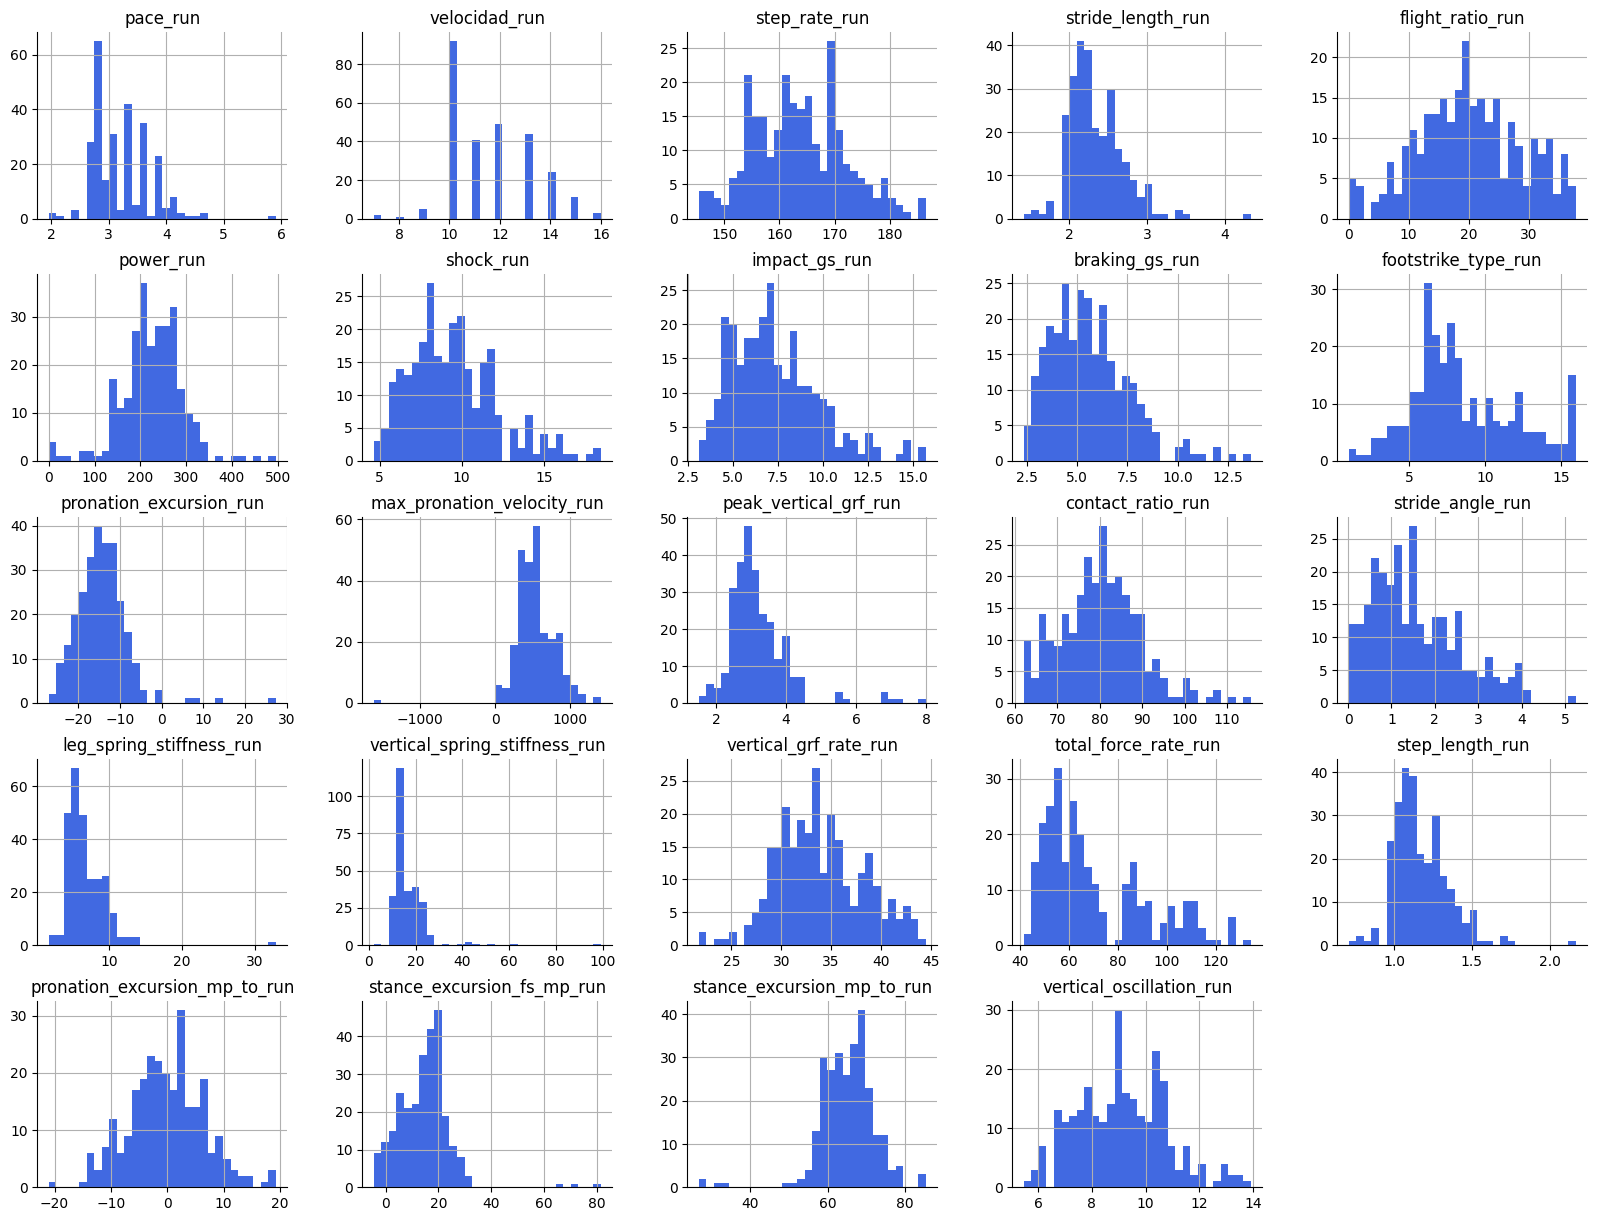

In [47]:
# Convertir a Pandas DataFrame para visualización
columns_of_interest = ['pace_run', 'velocidad_run', 'step_rate_run', 'stride_length_run', 'flight_ratio_run',
                       'power_run','shock_run', 'impact_gs_run', 'braking_gs_run', 'footstrike_type_run',
                       'pronation_excursion_run','max_pronation_velocity_run', 'peak_vertical_grf_run',
                       'contact_ratio_run', 'stride_angle_run','leg_spring_stiffness_run',
                       'vertical_spring_stiffness_run', 'vertical_grf_rate_run','total_force_rate_run',
                       'step_length_run','pronation_excursion_mp_to_run','stance_excursion_fs_mp_run',
                       'stance_excursion_mp_to_run', 'vertical_oscillation_run']

pandas_df = df.select(columns_of_interest).toPandas()

# Crear histogramas para cada columna
pandas_df.hist(figsize=(20, 15), bins=30, color="royalblue")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

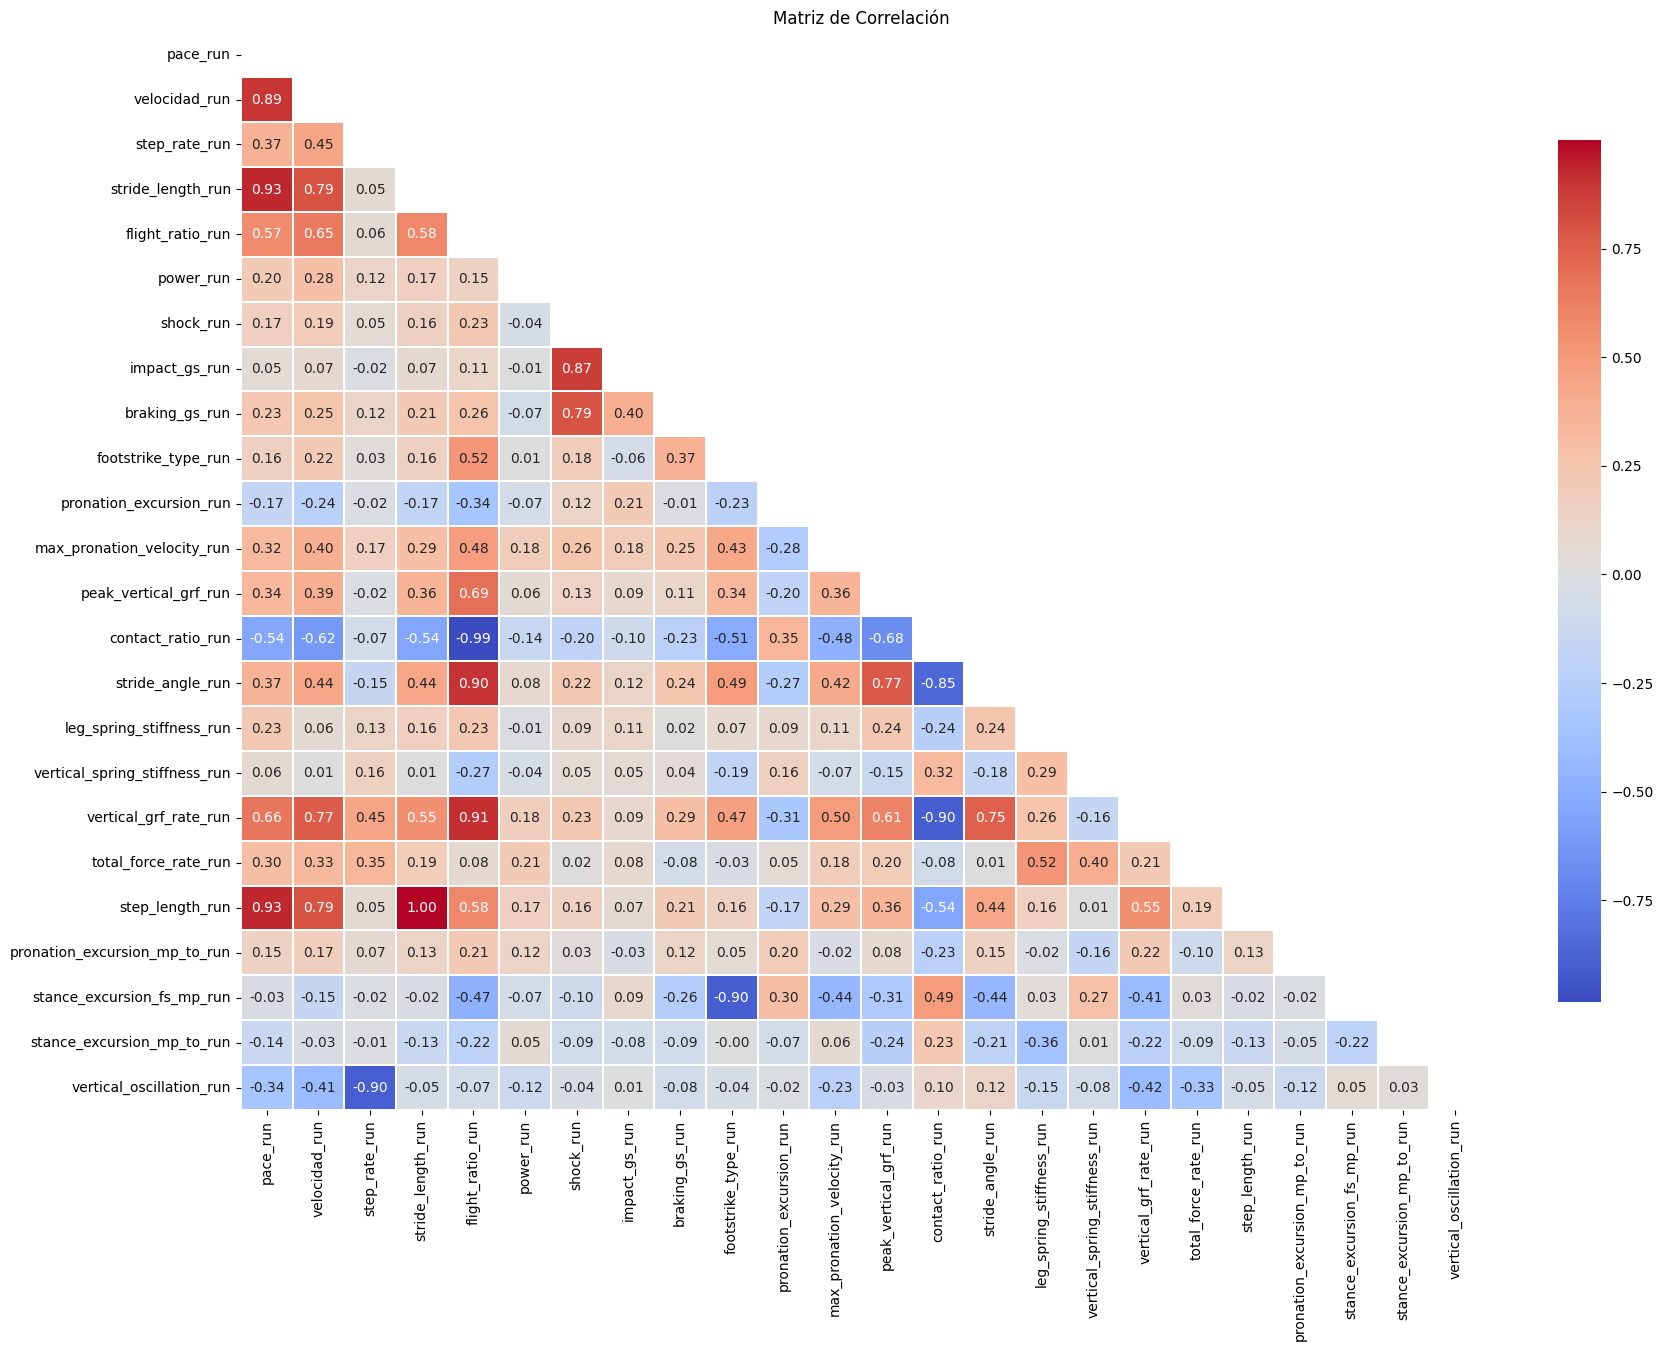

In [48]:
# Calcular la matriz de correlación
corr_matrix = pandas_df.corr()
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Visualizar la matriz de correlación
plt.figure(figsize=(20, 14))
sns.heatmap(corr_matrix, mask=mask, linewidths=.1, annot=True, 
            cmap='coolwarm', cbar_kws={"shrink": .8}, fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

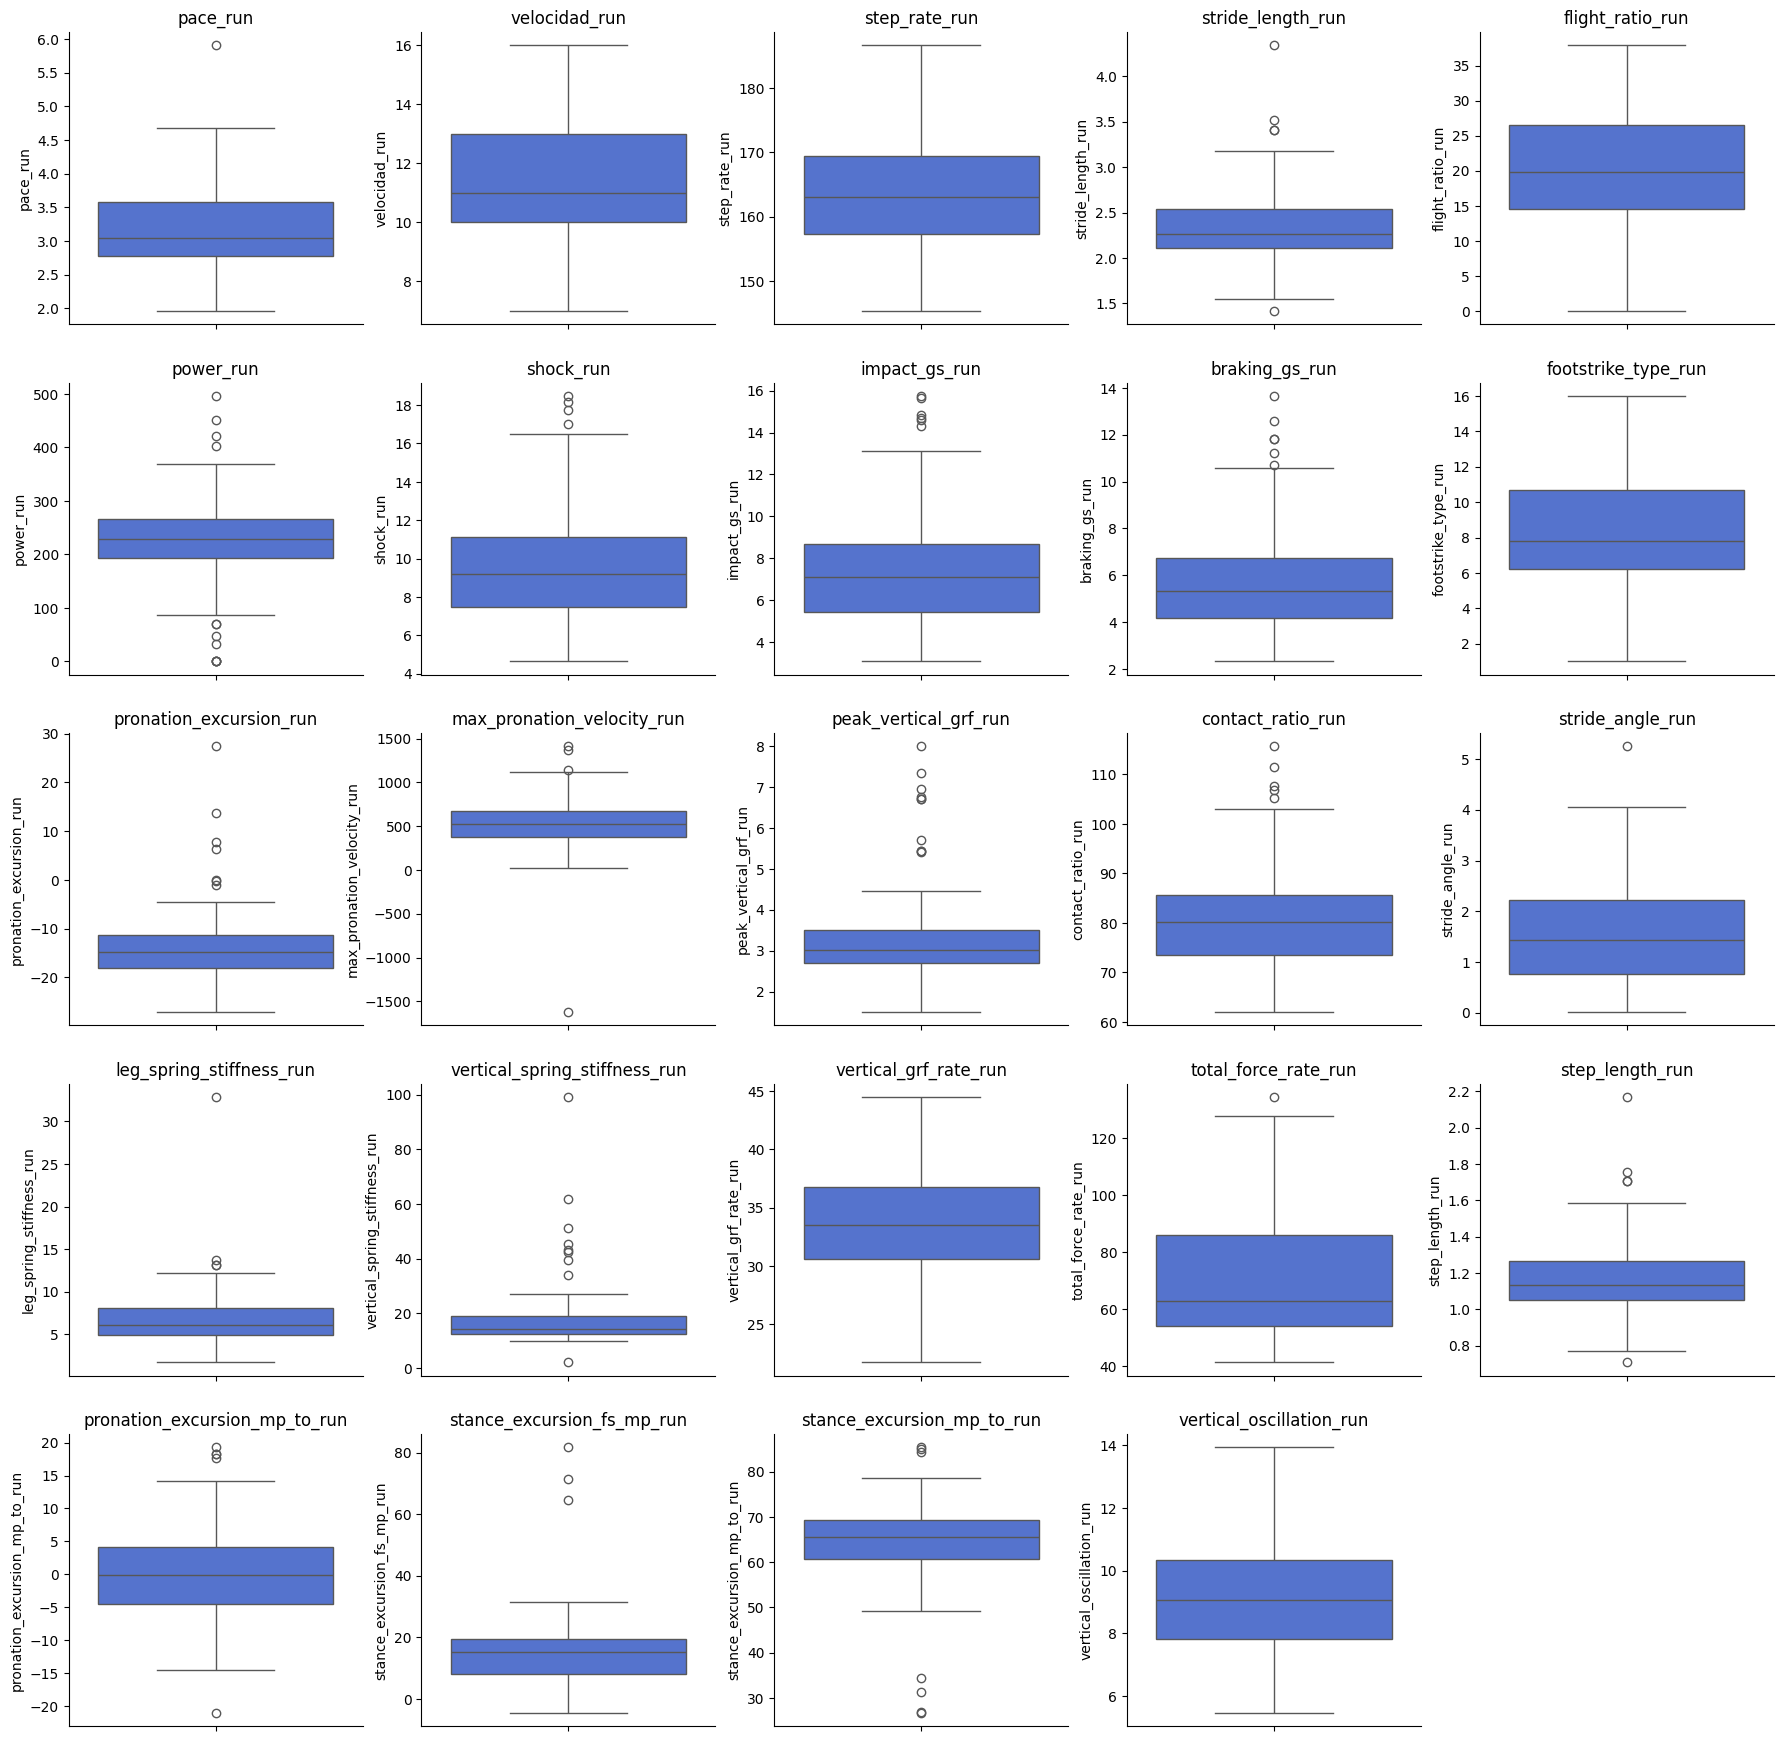

In [49]:
# Crear boxplots para cada columna
plt.figure(figsize=(22, 22))
for i, column in enumerate(columns_of_interest, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(data=pandas_df[column], color="royalblue")
    plt.title(column)
    sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [50]:
# Lista de columnas a evaluar
columns_to_evaluate = ['pace_run', 'velocidad_run', 'step_rate_run', 'stride_length_run', 
                       'flight_ratio_run', 'power_run', 'shock_run', 'impact_gs_run', 
                       'braking_gs_run', 'footstrike_type_run', 'pronation_excursion_run', 
                       'max_pronation_velocity_run', 'peak_vertical_grf_run', 'contact_ratio_run', 
                       'stride_angle_run', 'leg_spring_stiffness_run', 'vertical_spring_stiffness_run', 
                       'vertical_grf_rate_run', 'total_force_rate_run', 'step_length_run', 
                       'pronation_excursion_mp_to_run', 'stance_excursion_fs_mp_run', 
                       'stance_excursion_mp_to_run', 'vertical_oscillation_run']

# Función para identificar outliers
def identify_outliers(df, column):
    stats = df.select(mean(col(column)).alias('mean'),
                      stddev(col(column)).alias('stddev')).collect()
    mean_val = stats[0]['mean']
    stddev_val = stats[0]['stddev']
    
    # Definir los límites para los outliers
    lower_bound = mean_val - 3 * stddev_val
    upper_bound = mean_val + 3 * stddev_val
    
    # Filtrar outliers
    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return outliers

# Evaluar outliers para cada columna y mostrar resultados
for column_name in columns_to_evaluate:
    outliers_df = identify_outliers(df, column_name)
    outliers_count = outliers_df.count()
    print(f"Número de outliers en {column_name}: {outliers_count}")

Número de outliers en pace_run: 1
Número de outliers en velocidad_run: 0
Número de outliers en step_rate_run: 0
Número de outliers en stride_length_run: 4
Número de outliers en flight_ratio_run: 0
Número de outliers en power_run: 6
Número de outliers en shock_run: 3
Número de outliers en impact_gs_run: 4
Número de outliers en braking_gs_run: 4
Número de outliers en footstrike_type_run: 0
Número de outliers en pronation_excursion_run: 4
Número de outliers en max_pronation_velocity_run: 3
Número de outliers en peak_vertical_grf_run: 6
Número de outliers en contact_ratio_run: 2
Número de outliers en stride_angle_run: 1
Número de outliers en leg_spring_stiffness_run: 1
Número de outliers en vertical_spring_stiffness_run: 6
Número de outliers en vertical_grf_rate_run: 0
Número de outliers en total_force_rate_run: 1
Número de outliers en step_length_run: 4
Número de outliers en pronation_excursion_mp_to_run: 1
Número de outliers en stance_excursion_fs_mp_run: 3
Número de outliers en stance_e

In [51]:
# Guardar el DataFrame procesado en CSV
df_processed = df.toPandas()
df_processed.to_csv("../data/processed/spark/dataset_corredores_processed.csv", sep=";", index=False)

In [52]:
# Crear un DataFrame para los outliers
outliers_data = []
for column_name in columns_to_evaluate:
    outliers_df = identify_outliers(df, column_name)
    outliers_count = outliers_df.count()
    outliers_data.append((column_name, outliers_count))

outliers_df = pd.DataFrame(outliers_data, columns=['column', 'outliers_count'])
outliers_df.to_csv("../data/processed/spark/outliers_corredores.csv", sep=";", index=False)

In [53]:
# Calcular y guardar estadísticas descriptivas
selected_cols = ['edad','sexo','altura','peso','num_calzado','articulacion','localizacion','lado',
                 'actividad_principal','pace_run', 'velocidad_run', 'step_rate_run', 'stride_length_run',
                 'flight_ratio_run', 'power_run', 'shock_run', 'impact_gs_run','braking_gs_run',
                 'footstrike_type_run','pronation_excursion_run','max_pronation_velocity_run',
                 'peak_vertical_grf_run', 'contact_ratio_run','stride_angle_run','leg_spring_stiffness_run',
                 'vertical_spring_stiffness_run','vertical_grf_rate_run','total_force_rate_run',
                 'step_length_run','pronation_excursion_mp_to_run','stance_excursion_fs_mp_run',
                 'stance_excursion_mp_to_run','vertical_oscillation_run']

statistics = df[selected_cols].describe().toPandas()
statistics.to_csv("../data/processed/spark/statistics_corredores.csv", sep=";", index=False)

In [54]:
# Calcular y guardar matriz de correlación
correlation_matrix = df.select(columns_to_evaluate).toPandas().corr()
correlation_matrix.to_csv("../data/processed/spark/matrixcorr_corredores.csv", sep=";")

In [55]:
spark.stop() # Finalizar la sesión de Spark